In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import PIL
from matplotlib import pyplot as plt

# Downloading and preprocessing MNIST ds

In [24]:

# Преобразования для нормализации изображений
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))]) 

# Загрузка обучающего и тестового наборов данных MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

Тут возник вопрос, как праильно вычислять mean и std:
По всему data set'у или в каждом изображении/батче отдельно?

значения 0.5 и 0.5 были взяты из интернета, когда я гуглил про то, как скачать mnist

In [25]:
print('Train data set size:', len(train_dataset),'\n', 'Test data set size:', len(test_dataset))


Train data set size: 60000 
 Test data set size: 10000


## Making a Dataloader 

In [26]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Transfer to CUDA if it is available 

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device for running and trainning:', device)

Current device for running and trainning: cuda


Я юы хотел перенести dataset или dataloader сразу все данные, но попытки были безуспешны.

Как можно перенести данные на cuda до начала цикла обучения ?

там не так много данных и я могу себе позволить перенести весь датасет на видеокарту 

я не знаю как inplace изменить dataset или dataloader что бы применить one hot и labels. Придется каждый раз считать это в цикле обучения(

# Model creating and training

In [28]:
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


входное изображение 28х28

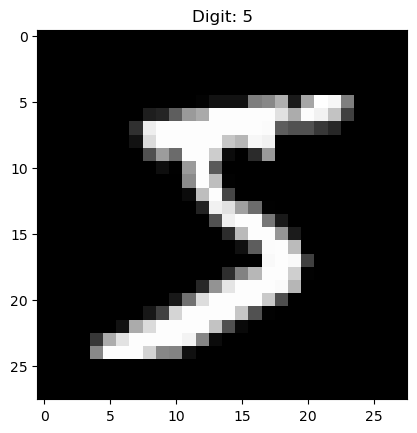

In [29]:
test_img, label = train_dataset[0]
test_img = test_img.squeeze()  # Убираем размерность канала, если она равна 1

# Вывод изображения с помощью Matplotlib
plt.imshow(test_img, cmap='gray')
plt.title(f"Digit: {label}")
plt.show()

обучающая функция

вынес ее отдельно тк она общая для каждой модели

In [30]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total_size = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            
            total_size += labels.shape[0]
            correct += int((predicted == labels).sum())
    #print("Accuracy:", correct / total_size)
    #print('True predicted', correct, '/', total_size)
        return correct, total_size

In [38]:
import datetime
num_classes = 10 # from 0 to 9

from TgReporter import send_learning_results

#labels = torch.empty(batch_size, num_classes, )
#labels = labels.to(device)

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    log_records = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader: 
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = torch.eye(num_classes).to(device)[labels]#.to(device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            log_rec1 = '\n{}\nEpoch {}\nTraining loss {}\n'.format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), epoch,
                loss_train / len(train_loader))

            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), epoch,
                loss_train / len(train_loader)))
            correct, total_size = evaluate_model(model, test_loader)

            log_rec2 = "Accuracy:" + str(correct / total_size) + '\n'
            print(log_rec2)
            log_records.append(log_rec1)
            log_records.append(log_rec2)
    #
    try:
        send_learning_results(log = log_records)
    except:
        print('Cant, send the result')
            

## Ordinary model
попробуем без Dropout, Batchnorm и Skipconnection

этот кусок кода я скопировал из книжки и немного дополнил - one hot encoding для lable

In [41]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

ordinary_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

ordinary_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(ordinary_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, ordinary_model, loss_fn, train_loader)
evaluate_model(ordinary_model, test_loader)

2023-08-26 15:29:28 Epoch 1, Training loss 1.3840321097006676
	Accuracy:0.8952
2023-08-26 15:31:24 Epoch 10, Training loss 0.07019082616879614
	Accuracy:0.9787
2023-08-26 15:33:35 Epoch 20, Training loss 0.04452780285191887
	Accuracy:0.9834
2023-08-26 15:35:47 Epoch 30, Training loss 0.03329354745317509
	Accuracy:0.9861
2023-08-26 15:38:01 Epoch 40, Training loss 0.026040701806716034
	Accuracy:0.9865
2023-08-26 15:40:16 Epoch 50, Training loss 0.020964564027249572
	Accuracy:0.9872
2023-08-26 15:42:27 Epoch 60, Training loss 0.017093962960612667
	Accuracy:0.9851
2023-08-26 15:44:37 Epoch 70, Training loss 0.013861957982973147
	Accuracy:0.9879
2023-08-26 15:46:52 Epoch 80, Training loss 0.011015284153674428
	Accuracy:0.9858
2023-08-26 15:49:00 Epoch 90, Training loss 0.009189979076925812
	Accuracy:0.987
2023-08-26 15:51:10 Epoch 100, Training loss 0.007476140212519604
	Accuracy:0.9868


(9868, 10000)

In [123]:
evaluate_model(ordinary_model, test_loader)

Accuracy: 0.9861
True predicted 9861 / 10000


Даже обычная сверточная модел без Dropout, Batchnorm и Skipconnection справилась на этом датасете неплохо(хотя и датасет простой)

1st Test:  
Точность: 98.74%  
Праильно: 9874 / 10_000  

2nd Test:  
Точность: 98.61%  
Праильно: 9861 / 10_000  
из-за своего косяка мне пришлось дважды обучить модель, поэтому тут два теста

3rd Test:
Точность: 98.89%  
Праильно: 9898 / 10_000  
лучший результат достигается в самом конце

Тут возникает вопрос, стоит ли улучшать модель, тк улучшения могут быть и не особо заметны, но почему бы и нет 

## Ordinary model + Tanh
Хочу протестировать с другой функцией активации 

Заменим все ReLU на Tanh

In [136]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

model_tanh = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.Tanh(),
            nn.Linear(32, 10))

model_tanh.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model_tanh.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_tanh, loss_fn, train_loader)

evaluate_model(model_tanh, test_loader)

2023-08-25 18:04:31 Epoch 1, Training loss 1.3120998711601248
	Accuracy: 0.8668
2023-08-25 18:06:19 Epoch 10, Training loss 0.11606150145517356
	Accuracy: 0.9707
2023-08-25 18:08:23 Epoch 20, Training loss 0.0729654192987051
	Accuracy: 0.979
2023-08-25 18:10:22 Epoch 30, Training loss 0.05647478429382163
	Accuracy: 0.9829
2023-08-25 18:12:22 Epoch 40, Training loss 0.04732624837296651
	Accuracy: 0.9843
2023-08-25 18:14:26 Epoch 50, Training loss 0.040922385865329966
	Accuracy: 0.9853
2023-08-25 18:16:25 Epoch 60, Training loss 0.03634378703873056
	Accuracy: 0.986
2023-08-25 18:18:26 Epoch 70, Training loss 0.032778651035551644
	Accuracy: 0.9869
2023-08-25 18:20:29 Epoch 80, Training loss 0.02968440427959188
	Accuracy: 0.9876
2023-08-25 18:22:28 Epoch 90, Training loss 0.027158318939474797
	Accuracy: 0.9868
2023-08-25 18:24:29 Epoch 100, Training loss 0.024912030065629774
	Accuracy: 0.9872


(9872, 10000)

Ну чет разницы вообще почти нет, на 2 стоые лучше чем у предыдущей модели те текущая модель предсказала правильно на 2 картики больше 

1st Test:  
Точность: 98.76%  
Праильно: 9876 / 10_000  

2nd Test:  
Точность: 98.72%  
Праильно: 9872 / 10_000  
после 80ой эпохи результат на 4 сотые процента лучше, скорее погрешность 

Так же я ожидал что она будет работать дольше, тк слышал из лекций, но и чисто логически понятно, что производная ReLU намного проще считается. 
Однако тут все же есть разница ~10 секунд дольше иногда для 10 эпох

## Ordinary model + Adam
Заменим SGD на Adam

In [137]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

adam_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

adam_model.to(device)

learning_rate = 1e-2

optimizer = optim.Adam(adam_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, adam_model, loss_fn, train_loader)


evaluate_model(adam_model, test_loader)

2023-08-25 18:24:45 Epoch 1, Training loss 0.18735437904959168
	Accuracy: 0.9722
2023-08-25 18:26:35 Epoch 10, Training loss 0.07436344940163223
	Accuracy: 0.9779
2023-08-25 18:28:35 Epoch 20, Training loss 0.06704386312204019
	Accuracy: 0.9756
2023-08-25 18:30:38 Epoch 30, Training loss 0.06595333824544819
	Accuracy: 0.9708
2023-08-25 18:32:44 Epoch 40, Training loss 0.06569145562139396
	Accuracy: 0.975
2023-08-25 18:34:43 Epoch 50, Training loss 0.06226704582299686
	Accuracy: 0.9761
2023-08-25 18:36:47 Epoch 60, Training loss 0.060985493739583604
	Accuracy: 0.9752
2023-08-25 18:38:51 Epoch 70, Training loss 0.062163011309166905
	Accuracy: 0.978
2023-08-25 18:40:51 Epoch 80, Training loss 0.057178736665409735
	Accuracy: 0.9773
2023-08-25 18:42:56 Epoch 90, Training loss 0.06171750899887138
	Accuracy: 0.9758
2023-08-25 18:44:59 Epoch 100, Training loss 0.06370039359106484
	Accuracy: 0.9727


(9727, 10000)

Adam сразу начал с низким Training loss'ом по сравнению с предыдущими моделями

Возможно на 40й эпохе нужно остановить. Нужно каждые 10 эпох проверять на тестовом датасете и выводить данные, проверка занимает не много времени. Обидно, как я раньше не додумался - теперь нужно будет перезапускачть все модели, что бы посмотреть на изменения точности на тесте. Для этого нужно дополнить функцию evaluate_model

1st Test:  
Точность: 97.43%  
Праильно: 9743 / 10_000    
Точность хуже, чем у предыдущих примерно на процент те на 100 неверных ответов больше 

2тв Test:  
Точность: 97.27%  
Праильно: 9727 / 10_000  
Как я и предполагал тут быстро происходит насыщение. и после 70ой эпохи точность падает на 6 десятых процента

## Ordinary model + DropOut
Добавим DropOut в обычную модель (с ReLU)

In [138]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

dropout_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(p=0.3), # 1st dropout

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Dropout(p=0.3), # 2nd dropout

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

dropout_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(dropout_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, dropout_model, loss_fn, train_loader)


evaluate_model(dropout_model, test_loader)

2023-08-25 18:45:14 Epoch 1, Training loss 1.3749489463023794
	Accuracy: 0.8773
2023-08-25 18:47:01 Epoch 10, Training loss 0.0749382493840749
	Accuracy: 0.9788
2023-08-25 18:49:01 Epoch 20, Training loss 0.046964089866223205
	Accuracy: 0.9822
2023-08-25 18:51:01 Epoch 30, Training loss 0.03534409180297199
	Accuracy: 0.9851
2023-08-25 18:52:59 Epoch 40, Training loss 0.028374327570825482
	Accuracy: 0.9867
2023-08-25 18:54:58 Epoch 50, Training loss 0.02277248651998714
	Accuracy: 0.9875
2023-08-25 18:56:58 Epoch 60, Training loss 0.018946958165965786
	Accuracy: 0.9868
2023-08-25 18:58:55 Epoch 70, Training loss 0.016052112233962978
	Accuracy: 0.9871
2023-08-25 19:00:55 Epoch 80, Training loss 0.013304501076941061
	Accuracy: 0.9869
2023-08-25 19:02:55 Epoch 90, Training loss 0.011527001280668636
	Accuracy: 0.9868
2023-08-25 19:04:53 Epoch 100, Training loss 0.009874266363403722
	Accuracy: 0.9864


(9864, 10000)

С р=0.3 результат не особо лучше обычной модели, возможно имеет смысл попробовать р побольше, но я боюсь, что из за наложения на начальных слоях останется мало нейронов


1st Test:  
Точность: 98.64%  
Праильно: 9764 / 10_000  
Тоже относительно быстро происходит насыщение лучший результат - 98.75% на 50ой эпохе 

## Ordinary model + BatchNorm
Добавим BatchNorm в обычную модель (с ReLU)  


In [139]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

batchnorm_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.BatchNorm2d( conv1_out_ch ), # 1st BatchNorm

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.BatchNorm2d( conv2_out_ch ), # 2nd BatchNorm

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),

            nn.BatchNorm1d(32),

            nn.Linear(32, 10))

batchnorm_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(batchnorm_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, batchnorm_model, loss_fn, train_loader)


evaluate_model(batchnorm_model, test_loader)

2023-08-25 19:05:09 Epoch 1, Training loss 0.389585454191671
	Accuracy: 0.9738
2023-08-25 19:07:01 Epoch 10, Training loss 0.027030378143566954
	Accuracy: 0.9853
2023-08-25 19:09:05 Epoch 20, Training loss 0.012746241657109721
	Accuracy: 0.989
2023-08-25 19:11:07 Epoch 30, Training loss 0.005298139848686593
	Accuracy: 0.9875
2023-08-25 19:13:12 Epoch 40, Training loss 0.0020841108131474033
	Accuracy: 0.9881
2023-08-25 19:15:15 Epoch 50, Training loss 0.0005142504325329684
	Accuracy: 0.9885
2023-08-25 19:17:17 Epoch 60, Training loss 0.00023568552932081774
	Accuracy: 0.9881
2023-08-25 19:19:22 Epoch 70, Training loss 0.0001606414651027439
	Accuracy: 0.9881
2023-08-25 19:21:25 Epoch 80, Training loss 0.00012169297149120584
	Accuracy: 0.9882
2023-08-25 19:23:29 Epoch 90, Training loss 9.596177190213616e-05
	Accuracy: 0.9882
2023-08-25 19:25:35 Epoch 100, Training loss 7.95941465593971e-05
	Accuracy: 0.9881


(9881, 10000)

Данная модель, наверное, показала самый лучший результат за обучение на 1ой эпохе
1st Test:  
Точность: 98.81%  
Праильно: 9781 / 10_000  
Лучший результат - 98.9 на 20ой эпохе 

## Ordinary model + DropOut с р=0.5
Добавим DropOut в обычную модель (с ReLU)

In [11]:

conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

dropout05_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(p=0.5), # 1st dropout

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Dropout(p=0.5), # 2nd dropout

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

dropout05_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(dropout05_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, dropout05_model, loss_fn, train_loader)


evaluate_model(dropout05_model, test_loader)

2023-08-26 10:29:56 Epoch 1, Training loss 1.6380273519929793
	Accuracy: 0.8326
2023-08-26 10:31:47 Epoch 10, Training loss 0.07574204474028304
	Accuracy: 0.9755
2023-08-26 10:33:47 Epoch 20, Training loss 0.0467621037948267
	Accuracy: 0.9857
2023-08-26 10:35:51 Epoch 30, Training loss 0.034718165360167745
	Accuracy: 0.9844
2023-08-26 10:37:52 Epoch 40, Training loss 0.026983658605784392
	Accuracy: 0.9873
2023-08-26 10:39:52 Epoch 50, Training loss 0.022238938759835902
	Accuracy: 0.9873
2023-08-26 10:41:55 Epoch 60, Training loss 0.017940459963748295
	Accuracy: 0.987
2023-08-26 10:43:55 Epoch 70, Training loss 0.014985951985389098
	Accuracy: 0.9884
2023-08-26 10:45:54 Epoch 80, Training loss 0.012904158337668958
	Accuracy: 0.9884
2023-08-26 10:47:53 Epoch 90, Training loss 0.010349543445444608
	Accuracy: 0.9887
2023-08-26 10:49:52 Epoch 100, Training loss 0.009093142805283696
	Accuracy: 0.9893


(9893, 10000)

Стало лучше на 2 десятых процента

1st Test:  
Точность: 98.85%  
Лучгий результат - 98.88 на 90ой эпохе

2nd Test:  
Точность: 98.93%  
Случайно запуститл второй раз, но вроде лучший результат по сравнению со всеми

## Ordinary model + DropOut(р=0.5) + BatchNorm
Добавим DropOut и BatchNorm в обычную модель (с ReLU)  
Batchnorm после Dropout

In [22]:

conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

d_b_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(p=0.5), # 1st 
            nn.BatchNorm2d( conv1_out_ch ), # 1st BatchNorm

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(p=0.5), # 2nd 
            nn.BatchNorm2d( conv2_out_ch ), # 2nd BatchNorm

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            
            nn.BatchNorm1d(32), # 3rd batchnorm

            nn.Linear(32, 10))

d_b_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(d_b_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, d_b_model, loss_fn, train_loader)


evaluate_model(d_b_model, test_loader)

2023-08-26 11:00:07 Epoch 1, Training loss 1.0098676786684533
	Accuracy: 0.9345
2023-08-26 11:02:02 Epoch 10, Training loss 0.039496858333195765
	Accuracy: 0.9862
2023-08-26 11:04:05 Epoch 20, Training loss 0.023167732430421917
	Accuracy: 0.9881
2023-08-26 11:06:16 Epoch 30, Training loss 0.014965355469565553
	Accuracy: 0.9878
2023-08-26 11:08:21 Epoch 40, Training loss 0.009213419598856843
	Accuracy: 0.9867
2023-08-26 11:10:25 Epoch 50, Training loss 0.0053512684803109474
	Accuracy: 0.9881
2023-08-26 11:12:30 Epoch 60, Training loss 0.0033945000688075425
	Accuracy: 0.989
2023-08-26 11:14:31 Epoch 70, Training loss 0.001581393994010791
	Accuracy: 0.9887
2023-08-26 11:16:31 Epoch 80, Training loss 0.0007032315937035115
	Accuracy: 0.9885
2023-08-26 11:18:32 Epoch 90, Training loss 0.0004270266325524881
	Accuracy: 0.9887
2023-08-26 11:20:32 Epoch 100, Training loss 0.00027878667411717045
	Accuracy: 0.9885


(9885, 10000)

Ну ничего особенного примерно те же значения, что и у остальных, примерно то что я и ожидал, хотя ,конечно, хотелось бы 99%   
Я пологая, что так произошло из-за недостаточной глубины/размерноти слоев.

1st Test:  
Точность: 98.85%  
Лучший результат - 98.87 на 90ой эпохе

## Wider conv layers Ordinary model
повысим размерность сверточных слоев

In [24]:
conv1_out_ch = 32
conv2_out_ch = 16
kernel_size = 3

wide_conv_ordinary_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

wide_conv_ordinary_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(wide_conv_ordinary_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, wide_conv_ordinary_model, loss_fn, train_loader)

2023-08-26 11:39:33 Epoch 1, Training loss 1.0107261456056698
	Accuracy: 0.8973
2023-08-26 11:41:32 Epoch 10, Training loss 0.05805535578498565
	Accuracy: 0.9837
2023-08-26 11:43:40 Epoch 20, Training loss 0.036632246226752437
	Accuracy: 0.9877
2023-08-26 11:45:43 Epoch 30, Training loss 0.026469037087677894
	Accuracy: 0.9891
2023-08-26 11:47:57 Epoch 40, Training loss 0.019431465918740343
	Accuracy: 0.9886
2023-08-26 11:50:02 Epoch 50, Training loss 0.014386922821417071
	Accuracy: 0.9905
2023-08-26 11:52:05 Epoch 60, Training loss 0.011258132575525168
	Accuracy: 0.9846
2023-08-26 11:54:19 Epoch 70, Training loss 0.008245408549893002
	Accuracy: 0.99
2023-08-26 11:56:26 Epoch 80, Training loss 0.006186401398528556
	Accuracy: 0.9898
2023-08-26 11:58:41 Epoch 90, Training loss 0.004697458321879143
	Accuracy: 0.99
2023-08-26 12:01:01 Epoch 100, Training loss 0.0036937927976698685
	Accuracy: 0.9897


ЕЕЕЕЕ уху 99%  
Как я и думал нужно было "расширить" слои

Надо было остановиться на 50ой эпохе

1st Test:  
Точность: 98.97%
Best: 99.05% на 50й эпохе 

## Wider conv layers Ordinary model + lr = 1e-3
повысим размерность сверточных слоев   
+ я хотел проверить как скажется уменьшение lr


In [25]:
conv1_out_ch = 32
conv2_out_ch = 16
kernel_size = 3

wide_conv_lr_ordinary_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

wide_conv_lr_ordinary_model.to(device)

learning_rate = 1e-3

optimizer = optim.SGD(wide_conv_lr_ordinary_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, wide_conv_lr_ordinary_model, loss_fn, train_loader)

2023-08-26 12:04:38 Epoch 1, Training loss 2.2857591300122517
	Accuracy: 0.2596
2023-08-26 12:06:47 Epoch 10, Training loss 0.3049766073333048
	Accuracy: 0.9214
2023-08-26 12:08:53 Epoch 20, Training loss 0.1730422174284008
	Accuracy: 0.9549
2023-08-26 12:11:11 Epoch 30, Training loss 0.12165618759554142
	Accuracy: 0.9682
2023-08-26 12:13:25 Epoch 40, Training loss 0.09704615961490219
	Accuracy: 0.9737
2023-08-26 12:15:31 Epoch 50, Training loss 0.08276069538890203
	Accuracy: 0.9771
2023-08-26 12:17:57 Epoch 60, Training loss 0.07300627716570728
	Accuracy: 0.9797
2023-08-26 12:20:06 Epoch 70, Training loss 0.0654491131384569
	Accuracy: 0.9806
2023-08-26 12:22:13 Epoch 80, Training loss 0.05991656813017929
	Accuracy: 0.981
2023-08-26 12:24:39 Epoch 90, Training loss 0.05498122352796958
	Accuracy: 0.9816
2023-08-26 12:26:44 Epoch 100, Training loss 0.05090208112551118
	Accuracy: 0.9834


ну чет не особо 
Теперь попробую увеличить

In [26]:
conv1_out_ch = 32
conv2_out_ch = 16
kernel_size = 3

wide_conv_lr_ordinary_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

wide_conv_lr_ordinary_model.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(wide_conv_lr_ordinary_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, wide_conv_lr_ordinary_model, loss_fn, train_loader)

2023-08-26 12:36:30 Epoch 1, Training loss 0.27649686131169643
	Accuracy: 0.9758
2023-08-26 12:38:22 Epoch 10, Training loss 0.016612038092631506
	Accuracy: 0.9844
2023-08-26 12:40:33 Epoch 20, Training loss 0.005398999979600226
	Accuracy: 0.9908
2023-08-26 12:42:54 Epoch 30, Training loss 0.0006353820371314669
	Accuracy: 0.9914
2023-08-26 12:45:01 Epoch 40, Training loss 0.00013546831767844277
	Accuracy: 0.9912
2023-08-26 12:47:20 Epoch 50, Training loss 8.133482572646335e-05
	Accuracy: 0.991
2023-08-26 12:49:32 Epoch 60, Training loss 5.931050342691132e-05
	Accuracy: 0.9908
2023-08-26 12:51:38 Epoch 70, Training loss 4.5838559885806646e-05
	Accuracy: 0.9907
2023-08-26 12:53:51 Epoch 80, Training loss 3.711113531807196e-05
	Accuracy: 0.9908
2023-08-26 12:55:59 Epoch 90, Training loss 3.1064888310348855e-05
	Accuracy: 0.9908
2023-08-26 12:58:09 Epoch 100, Training loss 2.6732946296808675e-05
	Accuracy: 0.9909


Получилось очень хорошо, я даже не ожидал 

теперь понизим lr еще на степень 10  
с lr=1 получилось очень плохо даже код оставлять не буду   
Но добавлю линейный слой

In [28]:
conv1_out_ch = 32
conv2_out_ch = 16
kernel_size = 3

model_1 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 128),
            nn.ReLU(),

            nn.Linear(128, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_1.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_1.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_1, loss_fn, train_loader)

2023-08-26 13:04:26 Epoch 1, Training loss 0.34054480788351565
	Accuracy: 0.9767
2023-08-26 13:06:34 Epoch 10, Training loss 0.011747342878796089
	Accuracy: 0.9903
2023-08-26 13:08:41 Epoch 20, Training loss 0.0015831269297298383
	Accuracy: 0.991
2023-08-26 13:10:56 Epoch 30, Training loss 9.184142955165057e-05
	Accuracy: 0.9917
2023-08-26 13:13:10 Epoch 40, Training loss 4.750197762293335e-05
	Accuracy: 0.9919
2023-08-26 13:15:16 Epoch 50, Training loss 3.1252571074842686e-05
	Accuracy: 0.9918
2023-08-26 13:17:32 Epoch 60, Training loss 2.3121484611579396e-05
	Accuracy: 0.9918
2023-08-26 13:19:40 Epoch 70, Training loss 1.8308243573243475e-05
	Accuracy: 0.9918
2023-08-26 13:21:48 Epoch 80, Training loss 1.5136188604218176e-05
	Accuracy: 0.9918
2023-08-26 13:24:03 Epoch 90, Training loss 1.2819438326595318e-05
	Accuracy: 0.9917
2023-08-26 13:26:08 Epoch 100, Training loss 1.1068048960773962e-05
	Accuracy: 0.9918


Хороший результат, почти везде 99% +  

1st Test:  
Точность: 99.18%
Best: 99.19% на 40й эпохе 

Попробую с другим lr (was 1e-1/ now 1e-2) 
+добавил уведомления в tg

In [34]:
conv1_out_ch = 32
conv2_out_ch = 16
kernel_size = 3

model_2 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 128),
            nn.ReLU(),

            nn.Linear(128, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_2.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model_2.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_2, loss_fn, train_loader)

2023-08-26 15:04:48 Epoch 1, Training loss 1.4951177743960544
	Accuracy:0.8562
2023-08-26 15:06:45 Epoch 10, Training loss 0.057379106373917355
	Accuracy:0.9812
2023-08-26 15:08:56 Epoch 20, Training loss 0.03071607626750688
	Accuracy:0.9855
2023-08-26 15:11:15 Epoch 30, Training loss 0.01938725820550673
	Accuracy:0.9888
2023-08-26 15:13:23 Epoch 40, Training loss 0.011992717817464077
	Accuracy:0.9896
2023-08-26 15:15:37 Epoch 50, Training loss 0.007712396837367023
	Accuracy:0.9894
2023-08-26 15:17:37 Epoch 60, Training loss 0.00487380933645715
	Accuracy:0.9884
2023-08-26 15:19:38 Epoch 70, Training loss 0.002874753110681108
	Accuracy:0.9891
2023-08-26 15:21:40 Epoch 80, Training loss 0.0020957217874670443
	Accuracy:0.9883
2023-08-26 15:23:42 Epoch 90, Training loss 0.0011124931918974651
	Accuracy:0.989
2023-08-26 15:25:44 Epoch 100, Training loss 0.0008736247336424264
	Accuracy:0.9894


Результат похуже - оставляем лр = 1е-1

Теперь добавим еще один линейный слой

In [43]:
conv1_out_ch = 32
conv2_out_ch = 16
kernel_size = 3

model_3 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_3.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_3.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_3, loss_fn, train_loader)

2023-08-26 17:02:53 Epoch 1, Training loss 0.5741520727347178
	Accuracy:0.9764
2023-08-26 17:05:09 Epoch 10, Training loss 0.012803756991981498
	Accuracy:0.9911
2023-08-26 17:07:38 Epoch 20, Training loss 0.0030695520578117477
	Accuracy:0.9905
2023-08-26 17:10:14 Epoch 30, Training loss 0.00011431614398513097
	Accuracy:0.9915
2023-08-26 17:12:40 Epoch 40, Training loss 3.336929594593406e-05
	Accuracy:0.9918
2023-08-26 17:15:13 Epoch 50, Training loss 1.9999376535839458e-05
	Accuracy:0.9918
2023-08-26 17:17:41 Epoch 60, Training loss 1.4335545297088819e-05
	Accuracy:0.9918
2023-08-26 17:20:11 Epoch 70, Training loss 1.0841767161864835e-05
	Accuracy:0.9918
2023-08-26 17:22:44 Epoch 80, Training loss 8.956036205864558e-06
	Accuracy:0.9919
2023-08-26 17:25:13 Epoch 90, Training loss 7.434653846143495e-06
	Accuracy:0.9919
2023-08-26 17:27:49 Epoch 100, Training loss 6.455055273199638e-06
	Accuracy:0.9919


Ничего особо не изменилось

Добавим еще один сверточный слой

+как посчитать размерность для первого линейного слоя ?

In [46]:
conv1_out_ch = 32
conv2_out_ch = 16
conv3_out_ch = 8
kernel_size = 3

model_4 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv2_out_ch, conv3_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv3_out_ch * 3 * 3, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_4.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_4.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_4, loss_fn, train_loader)

2023-08-26 17:49:06 Epoch 1, Training loss 1.0250194809083808
	Accuracy:0.9677
2023-08-26 17:51:28 Epoch 10, Training loss 0.025718436880930284
	Accuracy:0.9853
2023-08-26 17:53:58 Epoch 20, Training loss 0.011877770131613574
	Accuracy:0.9879
2023-08-26 17:56:27 Epoch 30, Training loss 0.007282938270187904
	Accuracy:0.9901
2023-08-26 17:59:01 Epoch 40, Training loss 0.00588299916120283
	Accuracy:0.9893
2023-08-26 18:01:31 Epoch 50, Training loss 0.002365109740194961
	Accuracy:0.9864
2023-08-26 18:04:08 Epoch 60, Training loss 8.505282166277163e-05
	Accuracy:0.9902
2023-08-26 18:06:26 Epoch 70, Training loss 3.2980386351594434e-05
	Accuracy:0.9902
2023-08-26 18:08:38 Epoch 80, Training loss 1.6062610572099095e-05
	Accuracy:0.9904
2023-08-26 18:10:50 Epoch 90, Training loss 1.1267333673051589e-05
	Accuracy:0.9904
2023-08-26 18:13:01 Epoch 100, Training loss 8.209344502942362e-06
	Accuracy:0.9905


Стало меньше тк входной ветор из за макспулинга стал еще меньше, попробуем это исправиь 

In [49]:
conv1_out_ch = 32
conv2_out_ch = 16
conv3_out_ch = 8
kernel_size = 3

model_5 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv2_out_ch, conv3_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv3_out_ch * 7 * 7, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_5.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_5.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_5, loss_fn, train_loader)

2023-08-26 18:36:07 Epoch 1, Training loss 1.047838811210589
	Accuracy:0.92
2023-08-26 18:38:29 Epoch 10, Training loss 0.018751384174163888
	Accuracy:0.9889
2023-08-26 18:40:59 Epoch 20, Training loss 0.008046414906706881
	Accuracy:0.9911
2023-08-26 18:43:27 Epoch 30, Training loss 0.005207747152446181
	Accuracy:0.9893
2023-08-26 18:45:55 Epoch 40, Training loss 0.003951341285933022
	Accuracy:0.9904
2023-08-26 18:48:24 Epoch 50, Training loss 2.8074604478064916e-05
	Accuracy:0.9914
2023-08-26 18:51:00 Epoch 60, Training loss 1.1932249959466628e-05
	Accuracy:0.9913
2023-08-26 18:53:28 Epoch 70, Training loss 7.64389783988106e-06
	Accuracy:0.9914
2023-08-26 18:56:04 Epoch 80, Training loss 5.612112213160838e-06
	Accuracy:0.9916
2023-08-26 18:58:34 Epoch 90, Training loss 4.418294767486649e-06
	Accuracy:0.9916
2023-08-26 19:01:02 Epoch 100, Training loss 3.638709350433004e-06
	Accuracy:0.9916


стало немного получше, но не сильно  
не думаю, что этот слой сильно влияет   

Попробую его убрать и увеличить число карт активации

In [51]:
conv1_out_ch = 128
conv2_out_ch = 64

kernel_size = 3

model_6 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_6.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_6.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_6, loss_fn, train_loader)

2023-08-26 19:04:19 Epoch 1, Training loss 0.44361017137142356
	Accuracy:0.9726
2023-08-26 19:06:44 Epoch 10, Training loss 0.006993106415214278
	Accuracy:0.9913
2023-08-26 19:09:23 Epoch 20, Training loss 0.00043088385822222393
	Accuracy:0.9923
2023-08-26 19:12:02 Epoch 30, Training loss 3.548040469271936e-05
	Accuracy:0.9925
2023-08-26 19:14:43 Epoch 40, Training loss 1.8899088819287472e-05
	Accuracy:0.9925
2023-08-26 19:17:23 Epoch 50, Training loss 1.300419809771089e-05
	Accuracy:0.9925
2023-08-26 19:20:03 Epoch 60, Training loss 9.918983907977972e-06
	Accuracy:0.9927
2023-08-26 19:22:42 Epoch 70, Training loss 7.995720888159677e-06
	Accuracy:0.9926
2023-08-26 19:25:21 Epoch 80, Training loss 6.629628871713884e-06
	Accuracy:0.9925
2023-08-26 19:28:00 Epoch 90, Training loss 5.667499471524441e-06
	Accuracy:0.9925
2023-08-26 19:30:39 Epoch 100, Training loss 4.954208765948891e-06
	Accuracy:0.9924


есть значительное улучшение, но насыщение досигается почти сразу  
Время работы сети значительно увеличилось. Предыдущие обучались за ~20 минут, то сейчас ~26

1st Test:  
Точность: 99.24%
Best: 99.27% на 60й эпохе 

Думаю размерность входново ветора большая для сети и нужно ее увеличить путем добавления линейных слоев и dropout'a

In [54]:
conv1_out_ch = 128
conv2_out_ch = 64

kernel_size = 3

model_6 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_6.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_6.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_6, loss_fn, train_loader)

2023-08-26 19:32:45 Epoch 1, Training loss 0.719354201511327
	Accuracy:0.965

2023-08-26 19:35:08 Epoch 10, Training loss 0.008070264120812713
	Accuracy:0.9919

2023-08-26 19:37:46 Epoch 20, Training loss 0.000498010350774564
	Accuracy:0.9924

2023-08-26 19:40:25 Epoch 30, Training loss 2.049967787460156e-05
	Accuracy:0.9927

2023-08-26 19:43:03 Epoch 40, Training loss 1.0536446375504065e-05
	Accuracy:0.9928

2023-08-26 19:45:42 Epoch 50, Training loss 7.14707752299601e-06
	Accuracy:0.9929

2023-08-26 19:48:21 Epoch 60, Training loss 5.353845137064032e-06
	Accuracy:0.9928

2023-08-26 19:50:59 Epoch 70, Training loss 4.272594302888849e-06
	Accuracy:0.9927

2023-08-26 19:53:38 Epoch 80, Training loss 3.5377128917404613e-06
	Accuracy:0.9927

2023-08-26 19:56:17 Epoch 90, Training loss 3.0195301598500237e-06
	Accuracy:0.9928

2023-08-26 19:58:56 Epoch 100, Training loss 2.621919798922384e-06
	Accuracy:0.9928



In [56]:
conv1_out_ch = 128
conv2_out_ch = 64

kernel_size = 3

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.BatchNorm2d( conv1_out_ch ),

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.BatchNorm1d(64),
            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-26 20:00:39 Epoch 1, Training loss 0.16828496586769692
	Accuracy:0.9795

2023-08-26 20:03:02 Epoch 10, Training loss nan
	Accuracy:0.098

2023-08-26 20:05:42 Epoch 20, Training loss nan
	Accuracy:0.098



KeyboardInterrupt: 

1ая Нормальзация все поламала 

In [58]:
conv1_out_ch = 128
conv2_out_ch = 64

kernel_size = 3

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            #nn.BatchNorm2d( conv1_out_ch ),

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.BatchNorm1d(64),
            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-26 20:08:00 Epoch 1, Training loss 0.19431658565148172
	Accuracy:0.9765

2023-08-26 20:10:23 Epoch 10, Training loss nan
	Accuracy:0.098

2023-08-26 20:13:01 Epoch 20, Training loss nan
	Accuracy:0.098

2023-08-26 20:15:40 Epoch 30, Training loss nan
	Accuracy:0.098



KeyboardInterrupt: 

не понимаю почему так

In [59]:
conv1_out_ch = 128
conv2_out_ch = 128

kernel_size = 3

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),


            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-26 20:18:02 Epoch 1, Training loss 0.6251057244634737
	Accuracy:0.9729

2023-08-26 20:20:25 Epoch 10, Training loss 0.005165174358302977
	Accuracy:0.992

2023-08-26 20:23:05 Epoch 20, Training loss 0.0014821180384100598
	Accuracy:0.9925

2023-08-26 20:25:43 Epoch 30, Training loss 2.4638966679781304e-05
	Accuracy:0.9928

2023-08-26 20:28:23 Epoch 40, Training loss 1.209994966387474e-05
	Accuracy:0.9929

2023-08-26 20:31:01 Epoch 50, Training loss 7.964848485364258e-06
	Accuracy:0.9927

2023-08-26 20:33:40 Epoch 60, Training loss 5.8729363963014036e-06
	Accuracy:0.9927

2023-08-26 20:36:19 Epoch 70, Training loss 4.6607176097883115e-06
	Accuracy:0.9927

2023-08-26 20:38:58 Epoch 80, Training loss 3.834166357358712e-06
	Accuracy:0.9928

2023-08-26 20:41:36 Epoch 90, Training loss 3.2460856372028343e-06
	Accuracy:0.9927

2023-08-26 20:44:15 Epoch 100, Training loss 2.8039327529625743e-06
	Accuracy:0.9926



Изменеие размера второй свертки не особо повлияло 
Попробую увеличить число карт активации и добавлю слой

In [61]:
conv1_out_ch = 256
conv2_out_ch = 128

kernel_size = 3

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-26 20:52:02 Epoch 1, Training loss 1.0497215066982835
Accuracy:0.9749

2023-08-26 20:55:02 Epoch 10, Training loss 0.006723085915375611
Accuracy:0.9919

2023-08-26 20:58:23 Epoch 20, Training loss 0.00018839034567259374
Accuracy:0.9935

2023-08-26 21:01:45 Epoch 30, Training loss 7.161747659345401e-05
Accuracy:0.9941

2023-08-26 21:05:05 Epoch 40, Training loss 1.1692264663161806e-05
Accuracy:0.994

2023-08-26 21:08:27 Epoch 50, Training loss 5.7541708288787225e-06
Accuracy:0.9942

2023-08-26 21:11:48 Epoch 60, Training loss 3.9080913309766514e-06
Accuracy:0.9942

2023-08-26 21:15:10 Epoch 70, Training loss 2.949779945847441e-06
Accuracy:0.9943

2023-08-26 21:18:30 Epoch 80, Training loss 2.3545971178618657e-06
Accuracy:0.9942

2023-08-26 21:21:52 Epoch 90, Training loss 1.9614544687796944e-06
Accuracy:0.9942

2023-08-26 21:25:12 Epoch 100, Training loss 1.6696898435728566e-06
Accuracy:0.9943



Повышение кол-во карт дало существенной прирост по сравнению с предыдущими моделями - думмаю нужно двигаться к их увеличению и увеличению слоев

In [10]:
conv1_out_ch = 1024
conv2_out_ch = 512

kernel_size = 3

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 2048),
            nn.ReLU(),

            nn.Linear(2048, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),
            
            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-27 05:30:01 Epoch 1, Training loss 1.9397288075705836
Accuracy:0.7197

2023-08-27 05:40:19 Epoch 10, Training loss 0.010710838393968202
Accuracy:0.9925

2023-08-27 05:51:41 Epoch 20, Training loss 0.0010164938588836932
Accuracy:0.9927

2023-08-27 06:03:02 Epoch 30, Training loss 2.1671703263522808e-05
Accuracy:0.9941

2023-08-27 06:14:25 Epoch 40, Training loss 8.166129207145503e-06
Accuracy:0.9941

2023-08-27 06:25:58 Epoch 50, Training loss 4.527776637581029e-06
Accuracy:0.9942

2023-08-27 06:37:27 Epoch 60, Training loss 3.028879287861703e-06
Accuracy:0.9942

2023-08-27 06:48:52 Epoch 70, Training loss 2.240915111124476e-06
Accuracy:0.9941

2023-08-27 07:00:21 Epoch 80, Training loss 1.7642279231504317e-06
Accuracy:0.994

2023-08-27 07:11:46 Epoch 90, Training loss 1.4458317705995075e-06
Accuracy:0.994

2023-08-27 07:23:14 Epoch 100, Training loss 1.2216452796530528e-06
Accuracy:0.994



0 результатов. Увеличение размера и кол-ва слоев не помогло 

Сначала задам равные conv1_out_ch = conv2_out_ch = 256, вместо conv2_out_ch = 128

Я тут тестил разные модели, которые удалил тк особых результатов от них нет и выводово особо тоже. Но вот вопросик один появился:  
Всегда ли последующие слои должны быть меньше, можно ли сделать их такими или больше? Как я понимаю начальные слои собирают низкоуровневую информацию, а последующие более высокоуровневую, и логично что низкору будет меньше, чем высокоур. Если привести аналогию то распознование лица - сначала распознование прямых и крывых линий - расспознование, условно, частей лица нос и тд - потом уже распознавание лица. Логично что кривых и прямых линий будет сильно больше, чем лиц.

In [15]:
conv1_out_ch = 256
conv2_out_ch = 128

kernel_size = 5

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-27 11:55:33 Epoch 1, Training loss 0.9384992567679362
Accuracy:0.9753

2023-08-27 11:59:04 Epoch 10, Training loss 0.008409673257561864
Accuracy:0.9919

2023-08-27 12:02:58 Epoch 20, Training loss 0.00012922786370984322
Accuracy:0.9934

2023-08-27 12:06:51 Epoch 30, Training loss 1.4310439179962322e-05
Accuracy:0.9934

2023-08-27 12:10:43 Epoch 40, Training loss 7.230054621017709e-06
Accuracy:0.9935

2023-08-27 12:14:37 Epoch 50, Training loss 4.759481349186521e-06
Accuracy:0.9936

2023-08-27 12:18:32 Epoch 60, Training loss 3.5251385771345635e-06
Accuracy:0.9937

2023-08-27 12:22:26 Epoch 70, Training loss 2.789405340655103e-06
Accuracy:0.9937

2023-08-27 12:26:23 Epoch 80, Training loss 2.2979096850921944e-06
Accuracy:0.9937

2023-08-27 12:30:19 Epoch 90, Training loss 1.9450729714554578e-06
Accuracy:0.9936

2023-08-27 12:34:16 Epoch 100, Training loss 1.6837195106209619e-06
Accuracy:0.9936



Тут отдельно хочу поэксперементировать с размером батча

тут я нашел небольшой косяк в коде и нужно функцию переопределить

полохая была идея...

почему то до этого момента более глубокии слои сверток были более узкими, попробую это поменять

https://tproger.ru/translations/neural-network-zoo-1/

In [36]:
conv1_out_ch = 128
conv2_out_ch = 256

kernel_size = 3

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-27 16:09:42 Epoch 1, Training loss 0.8798398897270245
Accuracy:0.9703

2023-08-27 16:12:24 Epoch 10, Training loss 0.006422967504411195
Accuracy:0.9904

2023-08-27 16:15:29 Epoch 20, Training loss 0.00017778021417556397
Accuracy:0.9935

2023-08-27 16:18:35 Epoch 30, Training loss 1.3667002999856187e-05
Accuracy:0.9931

2023-08-27 16:21:41 Epoch 40, Training loss 7.153756191634156e-06
Accuracy:0.9933

2023-08-27 16:24:44 Epoch 50, Training loss 4.776609574080017e-06
Accuracy:0.9933

2023-08-27 16:27:44 Epoch 60, Training loss 3.5685762851600713e-06
Accuracy:0.9933

2023-08-27 16:30:43 Epoch 70, Training loss 2.8460352039128354e-06
Accuracy:0.9933

2023-08-27 16:33:49 Epoch 80, Training loss 2.3438197777101854e-06
Accuracy:0.9934

2023-08-27 16:36:53 Epoch 90, Training loss 1.9898233368847297e-06
Accuracy:0.9934

2023-08-27 16:39:57 Epoch 100, Training loss 1.7266995217499767e-06
Accuracy:0.9934



# Skip connection

In [37]:
conv1_out_ch = 128
#conv2_out_ch = 256

kernel_size = 3

class SkipConv(nn.Module):
    def __init__(self, n_ch = 128, kernel_size = 3):
        super().__init__()
        self.n_chans1 = n_ch
        self.relu = nn.ReLU()
        self.conv2d = nn.Conv2d(n_ch, n_ch, kernel_size=kernel_size, padding=1)
    
    def forward(self, x):
        out = self.relu(self.conv2d(x))
        return out + x

model_7 = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # skip con start
            
            SkipConv(n_ch= conv1_out_ch, kernel_size=kernel_size),
            #x
            #out = nn.Conv2d(conv1_out_ch, conv1_out_ch, kernel_size=kernel_size, padding=1),
            #out= nn.ReLU(),
            #x + out


            # skip connection end
            

            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(conv1_out_ch * 7 * 7, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

model_7.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(model_7.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_7, loss_fn, train_loader)

2023-08-27 16:40:15 Epoch 1, Training loss 0.8309730087686926
Accuracy:0.9768

2023-08-27 16:42:39 Epoch 10, Training loss 0.011157308909804842
Accuracy:0.9929

2023-08-27 16:45:18 Epoch 20, Training loss 0.0024344149873257765
Accuracy:0.9934

2023-08-27 16:47:57 Epoch 30, Training loss 0.00011417159196535736
Accuracy:0.9937

2023-08-27 16:50:36 Epoch 40, Training loss 2.4062219069191723e-05
Accuracy:0.9939

2023-08-27 16:53:14 Epoch 50, Training loss 1.0882997679414942e-05
Accuracy:0.9939

2023-08-27 16:55:54 Epoch 60, Training loss 6.636198981263162e-06
Accuracy:0.9939

2023-08-27 16:58:32 Epoch 70, Training loss 4.677201194928006e-06
Accuracy:0.9939

2023-08-27 17:01:12 Epoch 80, Training loss 3.634082538007987e-06
Accuracy:0.9939

2023-08-27 17:03:51 Epoch 90, Training loss 2.9641801400934297e-06
Accuracy:0.9939

2023-08-27 17:06:29 Epoch 100, Training loss 2.4927990121787315e-06
Accuracy:0.9939



Добавлю еще один сверточный слой 

In [43]:
conv1_out_ch = 256
conv2_out_ch = 128

kernel_size = 3

class SkipConv(nn.Module):
    def __init__(self, n_ch = 256, kernel_size = 3):
        super().__init__()
        self.n_chans1 = n_ch
        self.relu = nn.ReLU()
        self.conv2d = nn.Conv2d(n_ch, n_ch, kernel_size=kernel_size, padding=1)
    
    def forward(self, x):
        out = self.relu(self.conv2d(x))
        return out + x

final_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # skip con start
            
            SkipConv(n_ch= conv1_out_ch, kernel_size=kernel_size),
            #x
            #out = nn.Conv2d(conv1_out_ch, conv1_out_ch, kernel_size=kernel_size, padding=1),
            #out= nn.ReLU(),
            #x + out


            # skip connection end
            

            nn.MaxPool2d(2),

            #3й сверточный слой 
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            # а что если не добавить макс пулинг


            nn.Flatten(),

            nn.Linear(conv2_out_ch * 7 * 7, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

final_model.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(final_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, final_model, loss_fn, train_loader)

2023-08-27 17:14:52 Epoch 1, Training loss 0.9711052795161189
Accuracy:0.9698

2023-08-27 17:18:24 Epoch 10, Training loss 0.009495700359587382
Accuracy:0.9908

2023-08-27 17:22:19 Epoch 20, Training loss 0.004351191368040678
Accuracy:0.9924

2023-08-27 17:26:13 Epoch 30, Training loss 9.085706549284093e-05
Accuracy:0.9925

2023-08-27 17:30:08 Epoch 40, Training loss 7.807668673342872e-06
Accuracy:0.9923

2023-08-27 17:34:03 Epoch 50, Training loss 4.212952766970865e-06
Accuracy:0.9923

2023-08-27 17:37:56 Epoch 60, Training loss 2.8453038275320317e-06
Accuracy:0.9924

2023-08-27 17:41:50 Epoch 70, Training loss 2.1385047320655724e-06
Accuracy:0.9924

2023-08-27 17:45:43 Epoch 80, Training loss 1.7017288948364649e-06
Accuracy:0.9924

2023-08-27 17:49:35 Epoch 90, Training loss 1.4102514238833308e-06
Accuracy:0.9924

2023-08-27 17:53:27 Epoch 100, Training loss 1.200461228102091e-06
Accuracy:0.9924



а теперь добавим пулинг

In [44]:
conv1_out_ch = 256
conv2_out_ch = 128

kernel_size = 3

class SkipConv(nn.Module):
    def __init__(self, n_ch = 256, kernel_size = 3):
        super().__init__()
        self.n_chans1 = n_ch
        self.relu = nn.ReLU()
        self.conv2d = nn.Conv2d(n_ch, n_ch, kernel_size=kernel_size, padding=1)
    
    def forward(self, x):
        out = self.relu(self.conv2d(x))
        return out + x

final_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # skip con start
            
            SkipConv(n_ch= conv1_out_ch, kernel_size=kernel_size),
            #x
            #out = nn.Conv2d(conv1_out_ch, conv1_out_ch, kernel_size=kernel_size, padding=1),
            #out= nn.ReLU(),
            #x + out


            # skip connection end
            

            nn.MaxPool2d(2),

            #3й сверточный слой 
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Flatten(),

            nn.Linear(conv2_out_ch * 3 * 3, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10))

final_model.to(device)

learning_rate = 1e-1

optimizer = optim.SGD(final_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, final_model, loss_fn, train_loader)

2023-08-27 17:53:52 Epoch 1, Training loss 1.2523899675011316
Accuracy:0.9677

2023-08-27 17:57:21 Epoch 10, Training loss 0.009862853464215025
Accuracy:0.9911

2023-08-27 18:01:12 Epoch 20, Training loss 0.003112531796822839
Accuracy:0.992

2023-08-27 18:05:02 Epoch 30, Training loss 7.967801176575928e-05
Accuracy:0.9938

2023-08-27 18:08:52 Epoch 40, Training loss 1.947875563521613e-05
Accuracy:0.994

2023-08-27 18:12:43 Epoch 50, Training loss 6.99052802631778e-06
Accuracy:0.9939

2023-08-27 18:16:33 Epoch 60, Training loss 4.413624695834941e-06
Accuracy:0.9936

2023-08-27 18:20:20 Epoch 70, Training loss 3.229604602775565e-06
Accuracy:0.9936

2023-08-27 18:24:09 Epoch 80, Training loss 2.533732556081434e-06
Accuracy:0.9936

2023-08-27 18:28:09 Epoch 90, Training loss 2.0699962397127995e-06
Accuracy:0.9936

2023-08-27 18:32:08 Epoch 100, Training loss 1.748571074323172e-06
Accuracy:0.9936

